In [1]:
import numpy as np


Text(0.5, 1.0, 'EM-BG-GAMP algorithm')

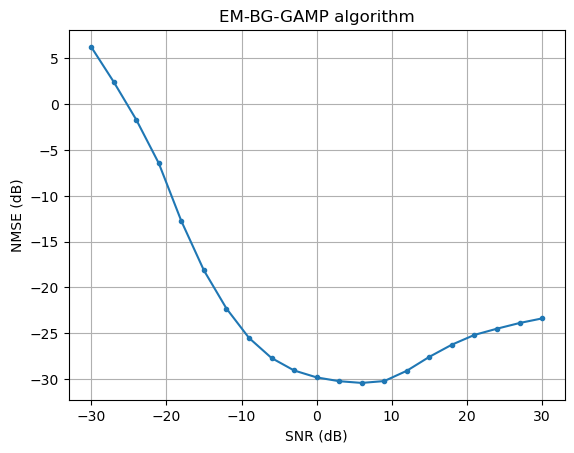

In [2]:
from matplotlib import pyplot as plt

from files_02_channel import gamp_curve

snrdb, nmse = gamp_curve.nmse_data()

plt.plot(snrdb, nmse, ".-")
plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("EM-BG-GAMP algorithm")


sum = 0j


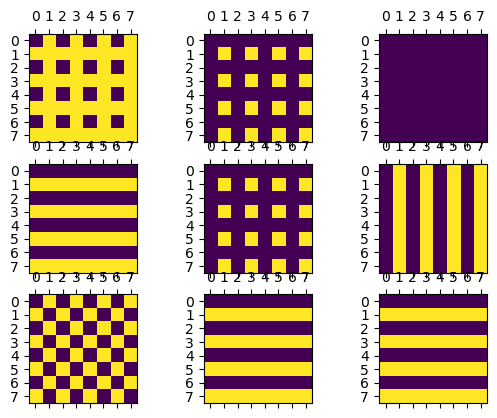

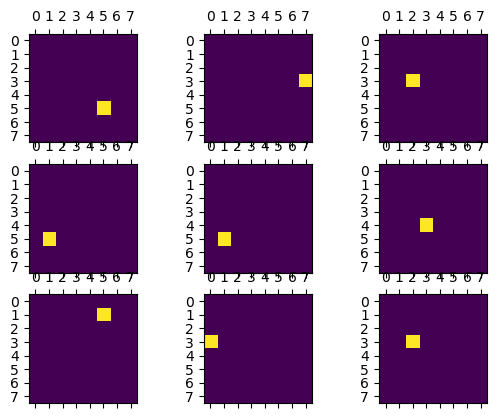

In [3]:
from files_02_channel import dataset

data = dataset.data()

antenna_channel, angle_channel = (data.get(key) for key in ["Harray", "Hvirtual"])
fig1, axs1 = plt.subplots(3, 3)
fig2, axs2 = plt.subplots(3, 3)
for i, ax in enumerate(axs1.flat):
    ax.matshow(np.abs(antenna_channel[i]))
for i, ax in enumerate(axs2.flat):
    ax.matshow(np.abs(angle_channel[i]))

angle_ch = angle_channel[0]

antenna_ch = np.fft.fft(
    np.fft.ifft(angle_ch, axis=-2, norm="ortho"), axis=-1, norm="ortho"
)

print(f"sum = {np.sum(antenna_ch - antenna_channel[0])}")


In [4]:
import tensorflow as tf
import math


In [5]:
def mse_db(y_true, y_pred):
    return (
        10
        * tf.math.log(tf.math.reduce_mean(tf.math.square(y_true - y_pred)))
        / math.log(10.0)
    )


In [6]:
from files_02_channel.low_res_mimo_ch_est.models import dense_model, residual_model
from tensorflow.keras.models import save_model, load_model


def get_model(Nr, Nt, T, model_type, should_include_x=False):
    if model_type == "dense":
        num_neurons = [256 for _ in range(10)]
        return dense_model(
            Nr,
            Nt,
            T,
            num_neurons,
            should_include_x=should_include_x,
            activation="tanh",
        )
    elif model_type == "residual":
        return residual_model(
            Nr, Nt, T, [400 for _ in range(3)], should_include_x=should_include_x
        )
    else:
        raise Exception("Invalid model name")


In [7]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)


def train(filename, training_generator=None, validation_generator=None, epochs=100):
    model = load_model(filename, custom_objects={"mse_db": mse_db})
    model.compile(loss=mse_db, optimizer="adam")
    history = model.fit(
        x=training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
        workers=1,
        use_multiprocessing=False,
        max_queue_size=16,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                min_delta=5e-3,
                patience=9,
                restore_best_weights=True,
            ),
            ModelCheckpoint(
                filepath=filename,
                monitor="val_loss",
                verbose=1,
                save_best_only=True,
            ),
            ReduceLROnPlateau(
                factor=0.5,
                min_delta=5e-2,
                patience=3,
                cooldown=5,
                verbose=1,
                min_lr=1e-6,
            ),
            TensorBoard(histogram_freq=1),
        ],
    )

    return history


In [8]:
import files_02_channel.low_res_mimo_ch_est.snr_generator as snr_gen


def test_by_snr(model, snr, test_generator=None):
    test_generator.set_snr_generator(snr_gen.constant_snr(snr))
    return model.evaluate(test_generator)


def test(filename, test_generator, snr_db=[]):
    model = load_model(filename, custom_objects={"mse_db": mse_db})

    return [test_by_snr(model, snr, test_generator) for snr in snr_db]


In [9]:
from files_02_channel.low_res_mimo_ch_est.pilotgen.qpsk_pilot_gen import QpskPilotGenerator
from files_02_channel.low_res_mimo_ch_est.channelgen.random_sparse_gen import (
    RandomSparseChannelGenerator,
)

from files_02_channel.low_res_mimo_ch_est.XYGenerator import XYGenerator

rand_gen = np.random.Generator(np.random.SFC64())

Nr = 8
Nt = 8
T = 256

should_include_x = False

model = get_model(Nr, Nt, T, "residual", should_include_x=should_include_x)

model.compile(loss=mse_db, optimizer="adam")
model.summary()

filename = "model.h5"

save_model(model, filename)

x_generator = QpskPilotGenerator(Nt, T, rand_gen, is_constant=True)

snr_range = (0, 21)

num_clusters = 1
channel_generators = {
    name: RandomSparseChannelGenerator(Nr, Nt, num_clusters, rand_gen)
    for name in ["train", "val", "test"]
}

trainConfig = {
    "num_batches": 1000,
    "batch_size": 32,
    "x_generator": x_generator,
    "channel_generator": channel_generators["train"],
    "snr_generator": snr_gen.uniform_snr(*snr_range, rand_gen),
    "quantizer": np.sign,
    "constant_batches": False,
    "should_include_x": should_include_x,
    "generator": rand_gen,
}

valConfig = {
    "num_batches": 100,
    "batch_size": 32,
    "x_generator": x_generator,
    "channel_generator": channel_generators["val"],
    "snr_generator": snr_gen.constant_snr(3),
    "quantizer": np.sign,
    "constant_batches": False,
    "should_include_x": should_include_x,
    "generator": rand_gen,
}

testConfig = {
    "num_batches": 1000,
    "batch_size": 32,
    "x_generator": x_generator,
    "channel_generator": channel_generators["test"],
    "snr_generator": snr_gen.uniform_snr(*snr_range, rand_gen),
    "quantizer": np.sign,
    "constant_batches": False,
    "should_include_x": should_include_x,
    "generator": rand_gen,
}


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 16)]    0           []                               
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 400)          1638800     ['flatten[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 400)          0           ['dense[0][0]']                  
                                                                                              

In [10]:
train(
    filename,
    training_generator=XYGenerator(**trainConfig),
    validation_generator=XYGenerator(**valConfig),
    epochs=100,
)


Epoch 1/100


2022-09-06 14:29:11.318875: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 998/1000 [============================>.] - ETA: 0s - loss: -10.8007
Epoch 1: val_loss improved from inf to -12.99279, saving model to model.h5
1000/1000 [==============================] - 10s 10ms/step - loss: -10.8045 - val_loss: -12.9928 - lr: 0.0010
Epoch 2/100
1000/1000 [==============================] - ETA: 0s - loss: -13.8526
Epoch 2: val_loss improved from -12.99279 to -14.42486, saving model to model.h5
1000/1000 [==============================] - 10s 10ms/step - loss: -13.8526 - val_loss: -14.4249 - lr: 0.0010
Epoch 3/100
1000/1000 [==============================] - ETA: 0s - loss: -14.7661
Epoch 3: val_loss improved from -14.42486 to -15.46465, saving model to model.h5
1000/1000 [==============================] - 10s 10ms/step - loss: -14.7661 - val_loss: -15.4647 - lr: 0.0010
Epoch 4/100
 998/1000 [============================>.] - ETA: 0s - loss: -15.5965
Epoch 4: val_loss improved from -15.46465 to -16.07193, saving model to model.h5
1000/1000 [=========================

In [11]:
nmse_db = test(
    filename,
    test_generator=XYGenerator(**testConfig),
    snr_db=np.arange(-30, 31, 3),
)


1000/1000 [==============================] - 5s 5ms/step - loss: -27.3880


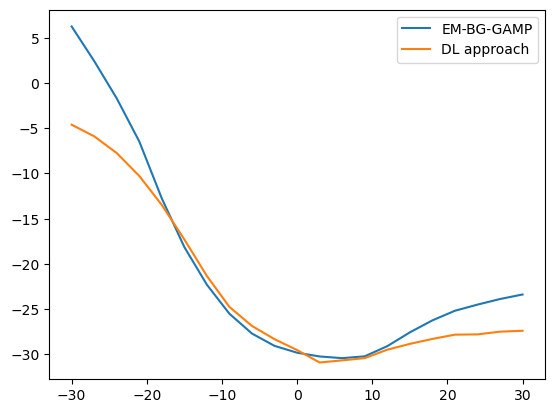

In [12]:
fig_res, ax_res = plt.subplots()
ax_res.plot(snrdb, nmse)
ax_res.plot(np.arange(-30, 31, 3), nmse_db)
ax_res.legend(["EM-BG-GAMP", "DL approach"])
